# New Environment: Creating and Modeling
<!-- 
<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/notebooks/1-quickstart.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/ai4co/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/ai4co/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us) -->

In this notebook, we will show how to extend RL4CO to solve new problems from zero to hero! 🚀

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/notebooks/tutorials/2-creating-new-env-model.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

### Contents

1. [Environment](#environment-creation)
2. [Modeling](#modeling)
3. [Training](#training-our-model)
4. [Evaluation](#evaluation)


### Problem: TSP

We will build an environment and model for the Traveling Salesman Problem (TSP). The TSP is a well-known combinatorial optimization problem that consists of finding the shortest route that visits each city in a given list exactly once and returns to the origin city. The TSP is NP-hard, and it is one of the most studied problems in combinatorial optimization.

### Installation

In [1]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# !pip install rl4co

### Imports

In [2]:
from typing import Optional
import torch
import torch.nn as nn

from tensordict.tensordict import TensorDict
from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.models.nn.utils import rollout, random_policy
from rl4co.envs.common.base import RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy
from rl4co.utils.ops import gather_by_index, get_tour_length
from rl4co.utils.trainer import RL4COTrainer

/home/botu/mambaforge/envs/rl4co-new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment Creation

We will base environment creation on the `RL4COEnvBase` class, which is based on [TorchRL](https://github.com/pytorch/rl). More information in [documentation](https://rl4co.readthedocs.io/en/latest/_content/api/envs/base.html)!

### Reset

The `_reset` function is used to initialize the environment to an initial state. It returns a TensorDict of the initial state.

In [3]:
def _reset(self, td: Optional[TensorDict] = None, batch_size=None) -> TensorDict:
    # Initialize locations
    init_locs = td["locs"] if td is not None else None
    if batch_size is None:
        batch_size = self.batch_size if init_locs is None else init_locs.shape[:-2]
    device = init_locs.device if init_locs is not None else self.device
    self.to(device)
    if init_locs is None:
        init_locs = self.generate_data(batch_size=batch_size).to(device)["locs"]
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # We do not enforce loading from self for flexibility
    num_loc = init_locs.shape[-2]

    # Other variables
    current_node = torch.zeros((batch_size), dtype=torch.int64, device=device)
    available = torch.ones(
        (*batch_size, num_loc), dtype=torch.bool, device=device
    )  # 1 means not visited, i.e. action is allowed
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "locs": init_locs,
            "first_node": current_node,
            "current_node": current_node,
            "i": i,
            "action_mask": available,
            "reward": torch.zeros((*batch_size, 1), dtype=torch.float32),
        },
        batch_size=batch_size,
    )

### Step

Environment `_step`: this defines the state update of the TSP problem gived a TensorDict (td in the code) of the current state and the action to take:

In [4]:
def _step(self, td: TensorDict) -> TensorDict:
    current_node = td["action"]
    first_node = current_node if td["i"].all() == 0 else td["first_node"]

    # Set not visited to 0 (i.e., we visited the node)
    # Note: we may also use a separate function for obtaining the mask for more flexibility
    available = td["action_mask"].scatter(
        -1, current_node.unsqueeze(-1).expand_as(td["action_mask"]), 0
    )

    # We are done there are no unvisited locations
    done = torch.sum(available, dim=-1) == 0

    # The reward is calculated outside via get_reward for efficiency, so we set it to 0 here
    reward = torch.zeros_like(done)

    td.update(
        {
            "first_node": first_node,
            "current_node": current_node,
            "i": td["i"] + 1,
            "action_mask": available,
            "reward": reward,
            "done": done,
        },
    )
    return td

### [Optional] Separate Action Mask Function

The `get_action_mask` function simply returns a mask of the valid actions for the current updated state. This can be used in `_step` and `_reset` for larger environments with several constraints and may be useful for modularity

In [5]:
def get_action_mask(self, td: TensorDict) -> TensorDict:
    # Here: your logic 
    return td["action_mask"]

### [Optional] Check Solution Validity

Another optional utility, this checks whether the solution is feasible and can help identify bugs 

In [6]:
def check_solution_validity(self, td: TensorDict, actions: torch.Tensor):
    """Check that solution is valid: nodes are visited exactly once"""
    assert (
        torch.arange(actions.size(1), out=actions.data.new())
        .view(1, -1)
        .expand_as(actions)
        == actions.data.sort(1)[0]
    ).all(), "Invalid tour"

### Reward function

The `get_reward` function is used to evaluate the reward given the solution (actions).

In [7]:
def get_reward(self, td, actions) -> TensorDict:
    # Sanity check if enabled
    if self.check_solution:
        self.check_solution_validity(td, actions)

    # Gather locations in order of tour and return distance between them (i.e., -reward)
    locs_ordered = gather_by_index(td["locs"], actions)
    return -get_tour_length(locs_ordered)

### Environment Action Specs

This defines the input and output domains of the environment - similar to Gym's `spaces`. 
This is not strictly necessary, but it is useful to have a clear definition of the environment's action and observation spaces and if we want to sample actions using TorchRL's utils

> Note: this is actually not necessary, but it is useful to have a clear definition of the environment's action and observation spaces and if we want to sample actions using TorchRL's utils

In [8]:
def _make_spec(self, td_params):
    """Make the observation and action specs from the parameters"""
    self.observation_spec = CompositeSpec(
        locs=BoundedTensorSpec(
            minimum=self.min_loc,
            maximum=self.max_loc,
            shape=(self.num_loc, 2),
            dtype=torch.float32,
        ),
        first_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(self.num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        minimum=0,
        maximum=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

### Data generation

This function allows for generating data for training instances if no data is provided.

In [9]:
def generate_data(self, batch_size) -> TensorDict:
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    locs = (
        torch.rand((*batch_size, self.num_loc, 2), generator=self.rng)
        * (self.max_loc - self.min_loc)
        + self.min_loc
    )
    return TensorDict({"locs": locs}, batch_size=batch_size)

### Render function

The `render` function is optional, but can be useful for quickly visualizing the results of your algorithm!

In [10]:
def render(self, td, actions=None, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        # Create a plot of the nodes
        _, ax = plt.subplots()

    td = td.detach().cpu()

    if actions is None:
        actions = td.get("action", None)
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]
        actions = actions[0]

    locs = td["locs"]

    # gather locs in order of action if available
    if actions is None:
        print("No action in TensorDict, rendering unsorted locs")
    else:
        actions = actions.detach().cpu()
        locs = gather_by_index(locs, actions, dim=0)

    # Cat the first node to the end to complete the tour
    locs = torch.cat((locs, locs[0:1]))
    x, y = locs[:, 0], locs[:, 1]

    # Plot the visited nodes
    ax.scatter(x, y, color="tab:blue")

    # Add arrows between visited nodes as a quiver plot
    dx, dy = np.diff(x), np.diff(y)
    ax.quiver(
        x[:-1], y[:-1], dx, dy, scale_units="xy", angles="xy", scale=1, color="k"
    )

    # Setup limits and show
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    plt.show()

### Putting everything together

In [11]:
class TSPEnv(RL4COEnvBase):
    """Traveling Salesman Problem (TSP) environment"""

    name = "tsp"

    def __init__(
        self,
        num_loc: int = 20,
        min_loc: float = 0,
        max_loc: float = 1,
        td_params: TensorDict = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc
        self._make_spec(td_params)
        
    _reset = _reset
    _step = _step
    get_reward = get_reward
    check_solution_validity = check_solution_validity
    get_action_mask = get_action_mask
    _make_spec = _make_spec
    generate_data = generate_data
    render = render


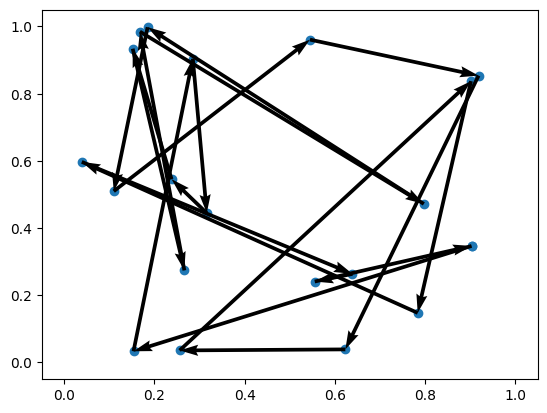

In [12]:
batch_size = 2

env = TSPEnv(num_loc=20)
reward, td, actions = rollout(env, env.reset(batch_size=[batch_size]), random_policy)
env.render(td, actions)

## Modeling

Now we need to model the problem by transforming input information into the latent space to be processed. In RL4CO, we divide embeddings in 3 parts:

- `init_embedding`: embed initial states of the problem
- `context_embedding`: embed context information of the problem for the current partial solution to modify the query 
- `dynamic_embedding`: embed dynamic information of the problem for the current partial solution to modify the query, key, and value (i.e. if other nodes also change state)

### Init Embedding

Embed initial problem into latent space. In our case, we can project the coordinates of the cities into a latent space.

In [13]:
class TSPInitEmbedding(nn.Module):
    """Initial embedding for the Traveling Salesman Problems (TSP).
    Embed the following node features to the embedding space:
        - locs: x, y coordinates of the cities
    """

    def __init__(self, embedding_dim, linear_bias=True):
        super(TSPInitEmbedding, self).__init__()
        node_dim = 2  # x, y
        self.init_embed = nn.Linear(node_dim, embedding_dim, linear_bias)

    def forward(self, td):
        out = self.init_embed(td["locs"])
        return out

### Context Embedding

Context embedding takes the current context and returns a vector representation of it. In TSP, we can take the embedding of the first node visited (since we need to complete the tour) as well as the embedding of current node visited (in the first step we just have a placeholder since they are the same).

In [14]:
class TSPContext(nn.Module):
    """Context embedding for the Traveling Salesman Problem (TSP).
    Project the following to the embedding space:
        - first node embedding
        - current node embedding
    """

    def __init__(self, embedding_dim,  linear_bias=True):
        super(TSPContext, self).__init__()
        self.W_placeholder = nn.Parameter(
            torch.Tensor(2 * embedding_dim).uniform_(-1, 1)
        )
        self.project_context = nn.Linear(
            embedding_dim*2, embedding_dim, bias=linear_bias
        )

    def forward(self, embeddings, td):
        batch_size = embeddings.size(0)
        # By default, node_dim = -1 (we only have one node embedding per node)
        node_dim = (
            (-1,) if td["first_node"].dim() == 1 else (td["first_node"].size(-1), -1)
        )
        if td["i"][(0,) * td["i"].dim()].item() < 1:  # get first item fast
            context_embedding = self.W_placeholder[None, :].expand(
                batch_size, self.W_placeholder.size(-1)
            )
        else:
            context_embedding = gather_by_index(
                embeddings,
                torch.stack([td["first_node"], td["current_node"]], -1).view(
                    batch_size, -1
                ),
            ).view(batch_size, *node_dim)
        return self.project_context(context_embedding)
    

### Dynamic Embedding

Since the states do not change except for visited nodes, we do not need to modify the keys and values. Therefore, we set this to 0

In [15]:
class StaticEmbedding(nn.Module):
    def __init__(self, *args, **kwargs):
        super(StaticEmbedding, self).__init__()

    def forward(self, td):
        return 0, 0, 0

## Training our Model

In [16]:
# Instantiate our environment
env = TSPEnv(num_loc=20)

# Instantiate policy with the embeddings we created above
emb_dim = 128
policy = AutoregressivePolicy(env,
                              embedding_dim=emb_dim,
                              init_embedding=TSPInitEmbedding(emb_dim),
                              context_embedding=TSPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)


# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env, 
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_000,
                       val_data_size=10_000) 

/home/botu/mambaforge/envs/rl4co-new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/botu/mambaforge/envs/rl4co-new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


### Rollout untrained model 

Problem 0 solution | Length = 6.29


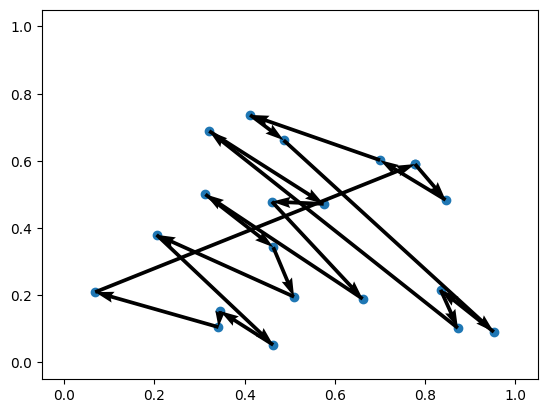

Problem 1 solution | Length = 6.04


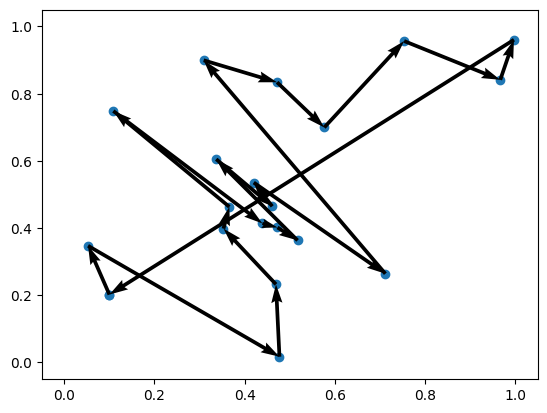

Problem 2 solution | Length = 7.93


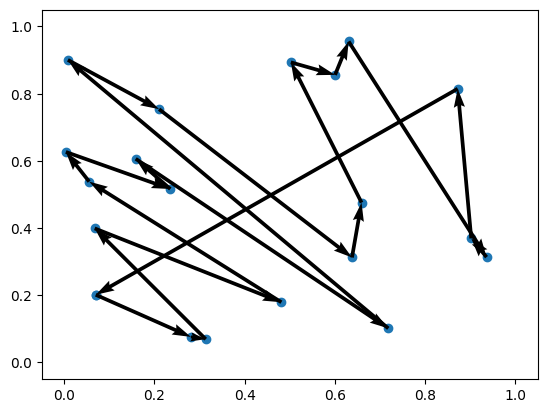

In [17]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
for i, (td, actions) in enumerate(zip(td_init, out['actions'].cpu())):
    print(f"Problem {i} solution | Length = {-out['reward'][i].item():.2f}")
    env.render(td, actions)

### Training loop

In [18]:
# We use our own wrapper around Lightning's `Trainer` to make it easier to use
trainer = RL4COTrainer(max_epochs=3, devices=1)
trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/botu/mambaforge/envs/rl4co-new/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /home/botu/Dev/parco/lib/rl4co/notebooks/tutorials/lightning_logs


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | TSPEnv               | 0     
1 | policy   | AutoregressivePolicy | 710 K 
2 | baseline | WarmupBaseline       | 710 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.682     Total estimated model params size (MB)


/home/botu/mambaforge/envs/rl4co-new/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/botu/mambaforge/envs/rl4co-new/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 196/196 [00:11<00:00, 17.46it/s, v_num=0, train/reward=-4.05, train/loss=-.0389, val/reward=-3.99] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 196/196 [00:19<00:00, 10.13it/s, v_num=0, train/reward=-4.05, train/loss=-.0389, val/reward=-3.99]


## Evaluation

Problem 0 solution | Length = 3.27


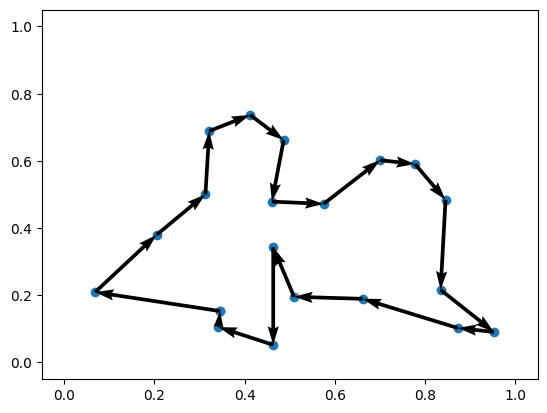

Problem 1 solution | Length = 4.36


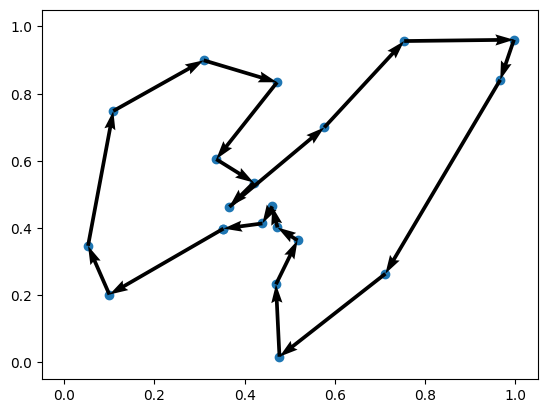

Problem 2 solution | Length = 4.25


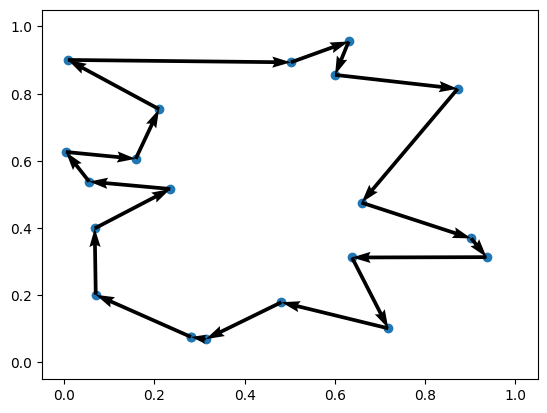

In [19]:
# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
for i, (td, actions) in enumerate(zip(td_init, out['actions'].cpu())):
    print(f"Problem {i} solution | Length = {-out['reward'][i].item():.2f}")
    env.render(td, actions)

We can see that solutions are way better than with the untrained model, even just after 3 epochs! 🚀